In [1]:
import zipfile
import gc
import copy
import pickle
import time
import scipy
import cv2
import torch
import torchvision
import faiss
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from pathlib import Path
from barbar import Bar
from ast import literal_eval
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from utils import display_image, visualize_nearest_neighbors
from model import FeaturizerModel

%matplotlib inline

In [26]:
image_path = './test_ds/60f18a93bc9a7f46c0e527de2a5b5615_Dresses_43720.jpg'
img_path_1 = './test_ds/62a0462ea47135763fa1f06d1df2ebcc_Shirts_&_Tops_31827.jpg'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
model = FeaturizerModel().to(device)
model.load_state_dict(torch.load('featurizer-model-1.pt', map_location=device)['model_state_dict'], strict=False)
model.eval()

FeaturizerModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): Conv2

In [4]:
transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [6]:
def get_latent_features(images, transformations):
    latent_features = []

    for image in tqdm(images):
        tensor = transformations(Image.open(image).convert("RGB").resize((128, 128))).to(device)
        feature = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy().flatten()
        latent_features.append(feature)

    return np.array(latent_features)

In [5]:
index_df = pd.read_csv('./index_df.csv')
index_df.head()

,filename,category,label_id,embeddings
0,./index_images/4095f53b27865649ae4be89e739f1de...,Shirts,2,"[2.123265027999878, 4.5380730628967285, 0.0, 5..."
1,./index_images/2a4c9a21b6302fb76ae9aa28235094b...,Shirts,2,"[2.659057855606079, 3.771310567855835, 1.27047..."
2,./index_images/bfcc15c4bd74347bb6336d266ace2a7...,Shirts,2,"[0.3487861454486847, 4.077633380889893, 2.0920..."
3,./index_images/cf880237d3e9683803d4a8a23fa456d...,Shirts,2,"[0.9752116799354553, 0.0, 1.9928834438323975, ..."
4,./index_images/d02f63672742c9efd5838017f46931f...,Shirts,2,"[12.112330436706543, 2.8348710536956787, 7.798..."


In [8]:
index_df['filename'] = index_df['filename'].str.replace('train_dataset', 'index_images')

In [7]:
images = index_df['filename'].values
latent_features = get_latent_features(images, transformations)

100%|██████████| 12225/12225 [02:30<00:00, 81.08it/s]


In [8]:
index_df['features'] = np.array(latent_features).tolist()

In [14]:
def get_latent_feature(image_path, transformation):
    feature = []
    tensor = transformations(Image.open(image_path).convert("RGB").resize((128, 128))).to(device)
    feature = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy().flatten()
    del tensor
    gc.collect()
    return np.array(feature)

In [16]:
img_paths = index_df['filename'].tolist()
embeddings = np.array(index_df['features'].tolist())

In [ ]:
index = ExactIndex(embeddings, img_paths)
index.build()

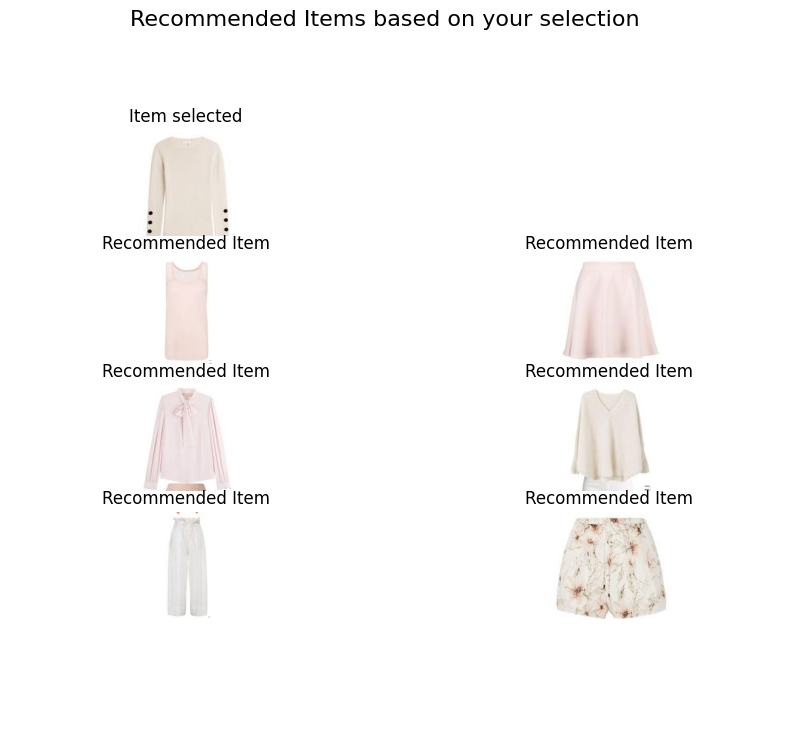

In [29]:
img_path_2 = './test_ds/0f1748a4586ce9bf856271b7664a590e_Shirts_&_Tops_28714.jpg'
selected_img_path = img_path_2
query_vector = get_latent_feature(selected_img_path, transformations)
query_vector = query_vector.reshape(1, -1)
query_vector.shape
selected_nearest_neighbors = index.query(query_vector, k=6)
visualize_nearest_neighbors(selected_img_path, selected_nearest_neighbors)

In [32]:
index_df = index_df.drop('embeddings', axis=1)

In [34]:
index_df = index_df.rename(columns={'features': 'embeddings'})

In [36]:
index_df.to_csv('index_df.csv', index=False)

In [37]:
index_path = 'flatIndex.index'
index.save(index_path)

In [38]:
# save img paths
img_paths_path = "img_paths.pkl"
with open(img_paths_path, 'wb') as file:
    pickle.dump(img_paths, file)

# save embeddings
embeddings_path = "embeddings.pkl"
with open(embeddings_path, 'wb') as file:
    pickle.dump(embeddings, file)

Test

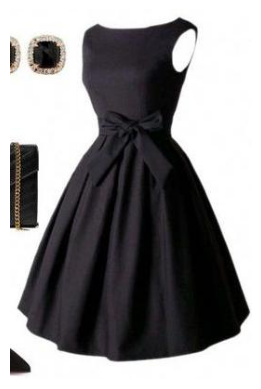

In [7]:
display_image(image_path)

In [8]:
def visualize_image(image_path, transformations):
    feature = []
    tensor = transformations(Image.open(image_path).convert("RGB").resize((128, 128))).to(device)
    feature = model.encoder(tensor.unsqueeze(0)).cpu().detach()

    # reconstruct image with decoder
    decoded_tensor = model.decoder(feature).squeeze(0)
    decoded_img = transforms.ToPILImage()(decoded_tensor.cpu())

    # plot images
    plt.figure(figsize=(10, 5))

    #original image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(Image.open(image_path).convert("RGB").resize((128, 128)))
    plt.axis('off')

    # reconstructed image
    plt.subplot(1, 2, 2)
    plt.title('reconstructed')
    plt.imshow(decoded_img)
    plt.axis('off')
    plt.show()

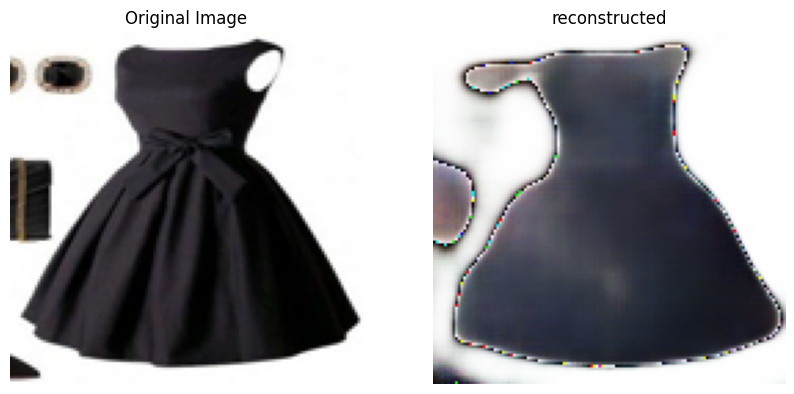

In [9]:
visualize_image(image_path, transformations)

In [ ]:
visualize_image(img_path_1, transformations)

In [10]:
root_dir = './train_dataset/'

In [11]:
train_df = pd.read_csv('./train_df_emb.csv')

In [12]:
train_df['filename'] = train_df['filename'].str.replace('/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset/train_dataset/', root_dir)

In [13]:
train_df.head(1)

,filename,category,label_id,embeddings
0,./train_dataset/4095f53b27865649ae4be89e739f1d...,Shirts,2,"[0.01364772580564022, 0.04184136539697647, 0.0..."


In [14]:
# set the number of rows to collect for each category
rows_per_cat = 1000

index_df = pd.DataFrame(columns=train_df.columns)

for cat in train_df['category'].unique():
    cat_rows = train_df[train_df['category'] == cat]

    if len(cat_rows) <= rows_per_cat:
        index_df = pd.concat([index_df, cat_rows])
    else:
        index_df = pd.concat([index_df, cat_rows.head(rows_per_cat)])

In [15]:
len(index_df)

12225

In [16]:
cat_counts = index_df['category'].value_counts().reset_index()
cat_counts.columns = ['category', 'count']
cat_counts

,category,count
0,Shirts,1000
1,Jewelry,1000
2,Dresses,1000
3,Handbags,1000
4,Shoes,1000
5,Skirts,1000
6,Hats,1000
7,Coats,1000
8,Pants,1000
9,Shorts,943


In [17]:
index_df.head()

,filename,category,label_id,embeddings
0,./train_dataset/4095f53b27865649ae4be89e739f1d...,Shirts,2,"[0.01364772580564022, 0.04184136539697647, 0.0..."
8,./train_dataset/2a4c9a21b6302fb76ae9aa28235094...,Shirts,2,"[0.025259610265493393, 0.029374826699495316, 0..."
11,./train_dataset/bfcc15c4bd74347bb6336d266ace2a...,Shirts,2,"[0.011484622955322266, 0.03411068022251129, 0...."
16,./train_dataset/cf880237d3e9683803d4a8a23fa456...,Shirts,2,"[0.026270370930433273, 0.0, 0.0492104850709438..."
17,./train_dataset/d02f63672742c9efd5838017f46931...,Shirts,2,"[0.07968679070472717, 0.02128513529896736, 0.0..."


In [125]:
len(img_paths)

12225

In [19]:
index_df.to_csv('index_df.csv', index=False)

In [18]:
img_paths = index_df['filename'].tolist()
index_df['embeddings'] = index_df['embeddings'].apply(literal_eval)
embeddings = np.array(index_df['embeddings'].tolist())

In [ ]:
img_paths

In [83]:
embeddings.shape[1]

512

In [15]:
class ExactIndex():
    def __init__(self, vectors, img_paths):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.img_paths = img_paths

    def build(self):
        self.index = faiss.IndexFlatL2(self.dimension)
        self.index.add(self.vectors)

    def query(self, vectors, k=10):
        distances, indices = self.index.search(vectors, k)
        return [self.img_paths[i] for i in indices[0]]
    
    def save(self, filename):
        faiss.write_index(self.index, filename)
    
    @classmethod
    def load(cls, vectors, img_paths, filename):
        instance = cls(vectors, img_paths, filename)
        instance.index = faiss.read_index(filename)
        return instance

In [ ]:
index = ExactIndex(embeddings, img_paths)
index.build()
img_path_2 = './test_ds/0b212a69ec00380507d91c72efb69842_Handbags_21028.jpg'
selected_img_path = img_path_2
query_vector = get_latent_feature(selected_img_path, transformations)
query_vector = query_vector.reshape(1, -1)
query_vector.shape
selected_nearest_neighbors = index.query(query_vector, k=7)
visualize_nearest_neighbors(selected_img_path, selected_nearest_neighbors)

In [147]:
index = ExactIndex(embeddings, img_paths)
index.build()

In [76]:
img_path_2 = './test_ds/0b212a69ec00380507d91c72efb69842_Handbags_21028.jpg'

In [164]:
selected_img_path = img_path_2

In [165]:
query_vector = get_latent_feature(selected_img_path, transformations)
query_vector = query_vector.reshape(1, -1)
query_vector.shape

(1, 512)

In [166]:
nearest_neighbors = index.query(query_vector, k=7)

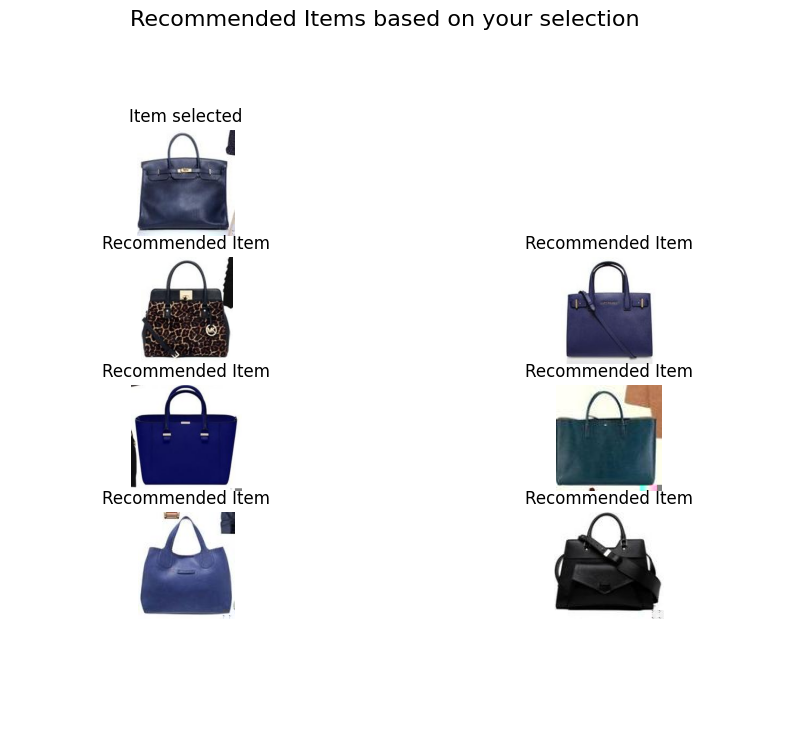

In [167]:
selected_nearest_neighbors = nearest_neighbors[1:]
visualize_nearest_neighbors(selected_img_path, selected_nearest_neighbors)

In [153]:
index_path = 'flatIndex.index'
index.save(index_path)

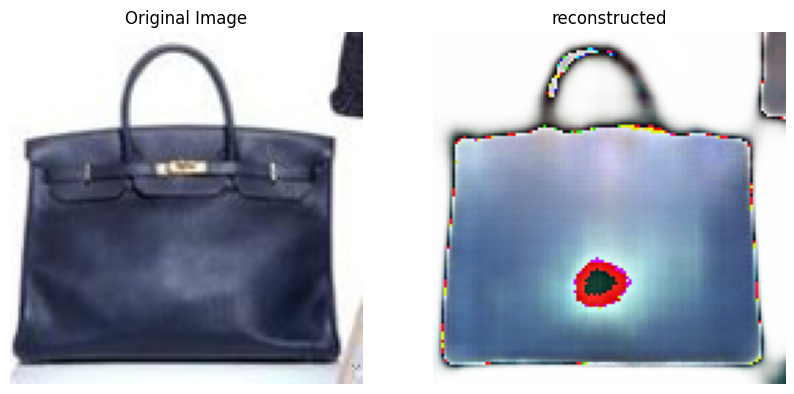

In [168]:
visualize_image(img_path_2, transformations)

In [117]:
query_vector = [embeddings[4567]]
query_vector = np.array(query_vector, dtype=np.float32)

In [118]:
nearest_neighbors = index.query(query_vector, k=7)

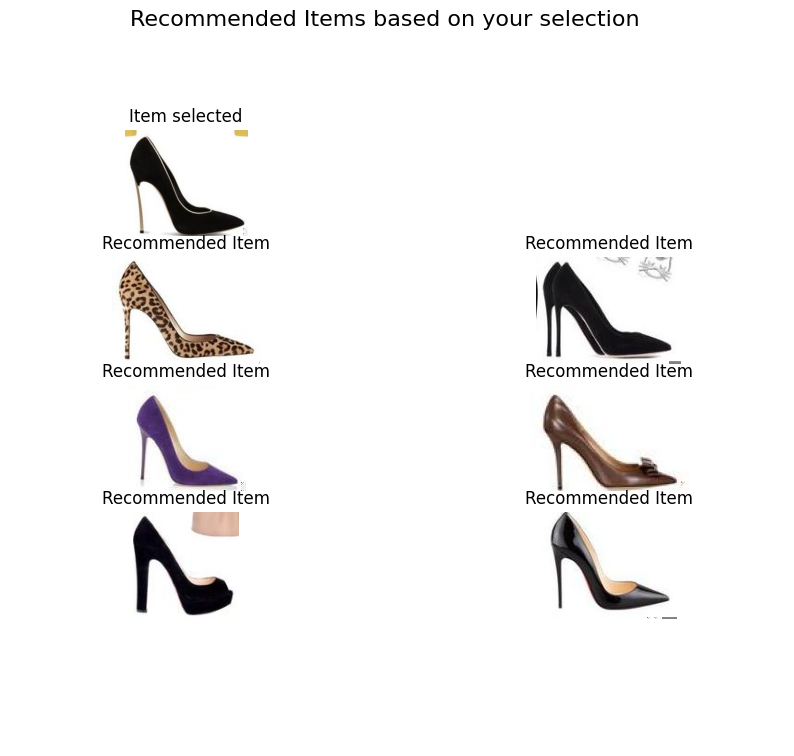

In [120]:
selected_nearest_neighbors = nearest_neighbors[1:]
selected_img_path = img_paths[4567]
visualize_nearest_neighbors(selected_img_path, selected_nearest_neighbors)

In [123]:
# save img paths
img_paths_path = "img_paths.pkl"
with open(img_paths_path, 'wb') as file:
    pickle.dump(img_paths, file)

# save embeddings
embeddings_path = "embeddings.pkl"
with open(embeddings_path, 'wb') as file:
    pickle.dump(embeddings, file)

In [129]:
len(img_paths), img_paths[0], img_paths[1]

(12225,
 './train_dataset/4095f53b27865649ae4be89e739f1de7_Shirts_&_Tops_5652.jpg',
 './train_dataset/2a4c9a21b6302fb76ae9aa28235094b0_Shirts_&_Tops_23697.jpg')

In [130]:
destination_folder = './index_images/'
os.makedirs(destination_folder, exist_ok=True)

In [ ]:
def move_images(img_paths, destination_folder):
    for img_path in img_paths:
        source_path = img_path
        destination_path = os.path.join(destination_folder, os.path.basename(img_path))
        
        # Make sure the source file exists before moving
        if os.path.exists(source_path):
            # Move the file
            shutil.move(source_path, destination_path)
            print(f"Moved {img_path} to {destination_folder}")
        else:
            print(f"File {img_path} not found")

move_images(img_paths, destination_folder)


In [136]:
img_paths = [path.replace('./train_dataset', './index_images') for path in img_paths]

#### Visualizations

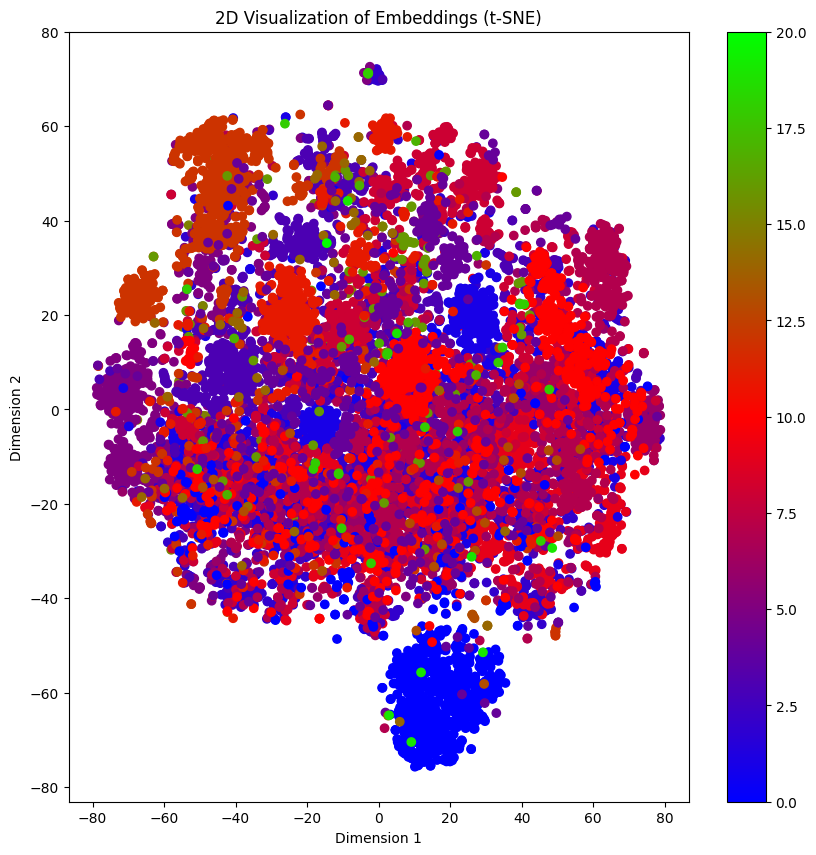

In [20]:
from sklearn.manifold import TSNE

embeddings = np.vstack(index_df['embeddings'].values)

# Perform dimensionality reduction using t-SNE to get 2D embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

# Add the 2D embeddings back to the DF
index_df['embeddings_0_tsne'] = embeddings_2d_tsne[:, 0]
index_df['embeddings_1_tsne'] = embeddings_2d_tsne[:, 1]

# Plot the 2D scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(index_df['embeddings_0_tsne'], index_df['embeddings_1_tsne'], c=index_df['label_id'], cmap='brg')
plt.colorbar()
plt.title('2D Visualization of Embeddings (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Tensorboard

In [6]:
from torchvision import transforms
from torchvision.utils import make_grid

In [7]:
image_paths = index_df['filename'].tolist()
index_df['embeddings'] = index_df['embeddings'].apply(literal_eval)
embeddings = np.array(index_df['embeddings'].tolist())

In [8]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_exp_3')

In [9]:
# Add the embeddings to TensorBoard
writer.add_embedding(embeddings, metadata=index_df['category'].values, tag='fashion_embeddings')

# Close the TensorBoard writer
writer.close()

Visualizing each layer in the encoding network

In [100]:
len(model.encoder)

19

In [164]:
def ext_inter_features(model, x, target_layer):
    features = []
    for i, layer in enumerate(model.encoder):
        x = layer(x)
        if i == target_layer:
            features.append(x.clone().detach())
    return features

In [ ]:
# The code blocks in this cell is not used.
# The code blocks in the next cell is used instead (It serves almost the same purpose)

def visualize_features(features):
    num_features = len(features)

    for i in range(num_features):
        feature = features[i][0, 0].cpu().detach()  # Assuming a single channel for simplicity
        print(len(feature))
        plt.imshow(feature, cmap='gray')
        plt.axis('off')
        plt.title(f'Feature')
        plt.show()

def viz_inter_features(image_path, transformations, model, target_layer):
    # Load and preprocess the image
    tensor = transformations(Image.open(image_path).convert("RGB").resize((128, 128))).to(device)

    # Extract intermediate features from the target layer
    intermediate_features = ext_inter_features(model, tensor.unsqueeze(0), target_layer)

    # Visualize the intermediate features
    visualize_features(intermediate_features)

for i in range(len(model.encoder)):
    viz_inter_features(img_path_2, transformations, model, i)

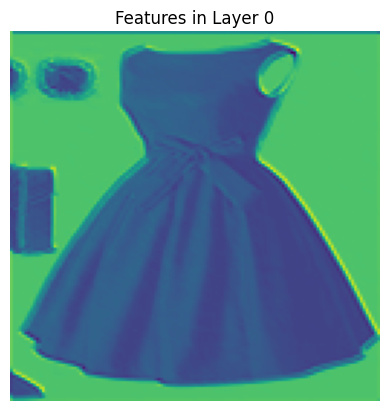

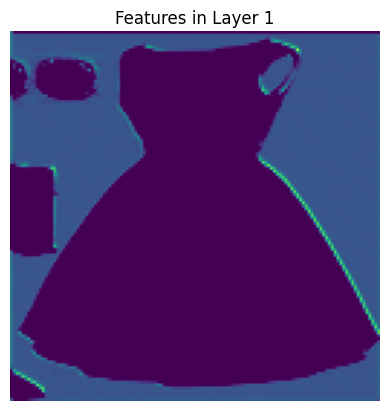

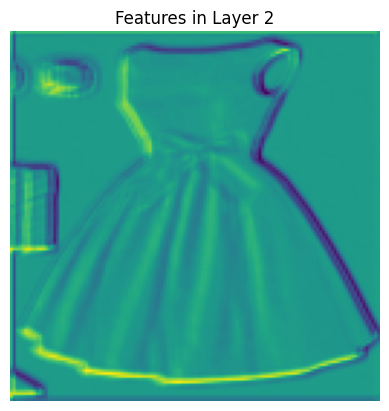

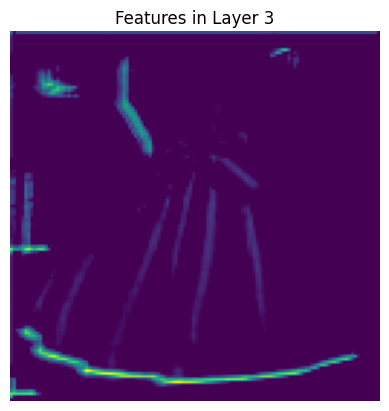

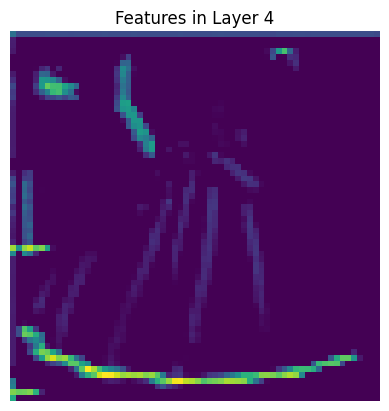

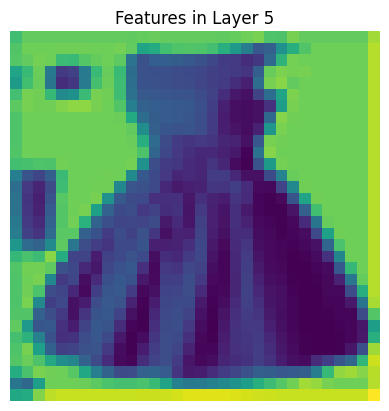

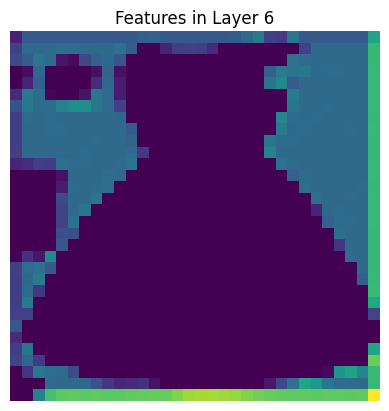

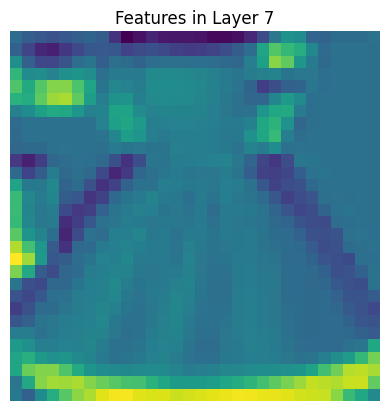

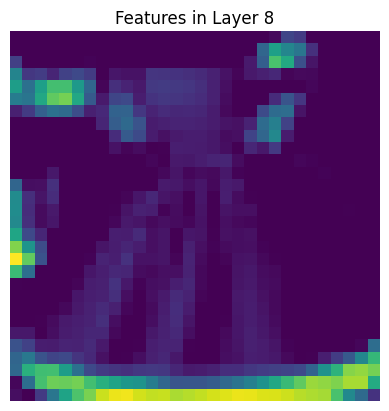

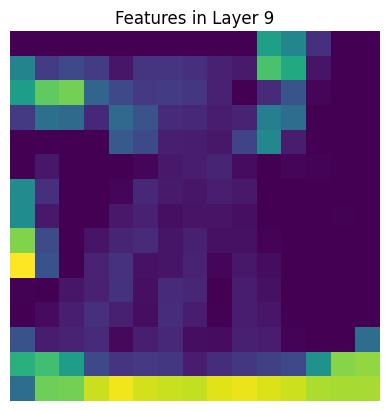

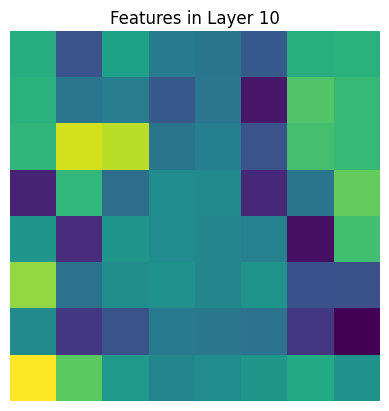

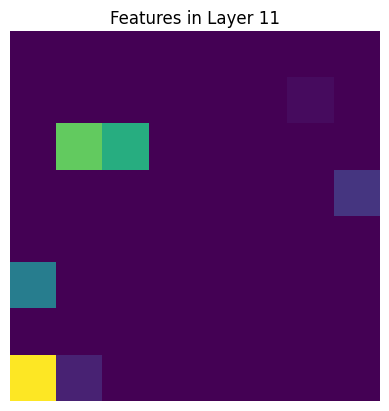

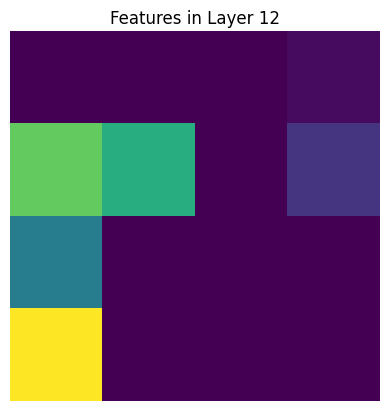

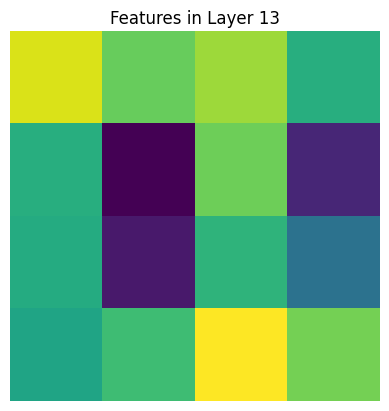

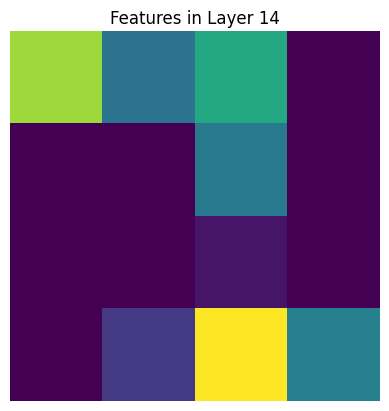

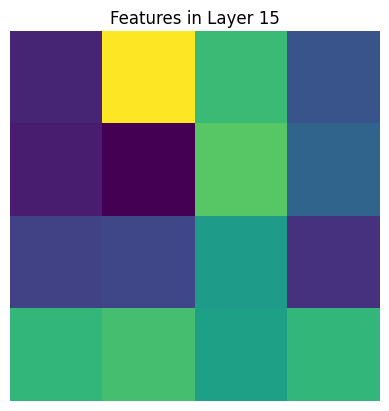

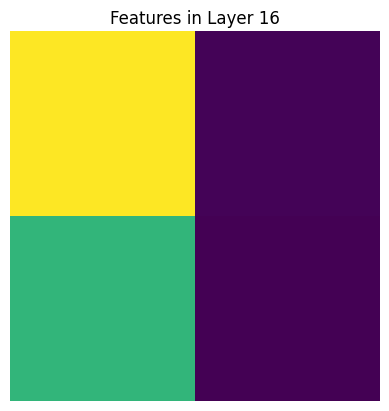

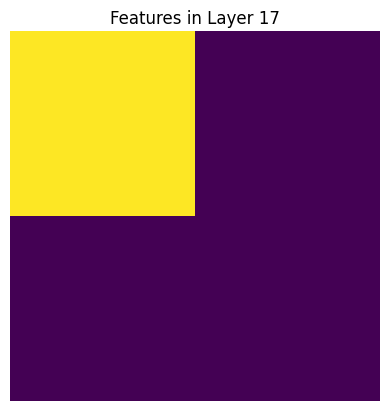

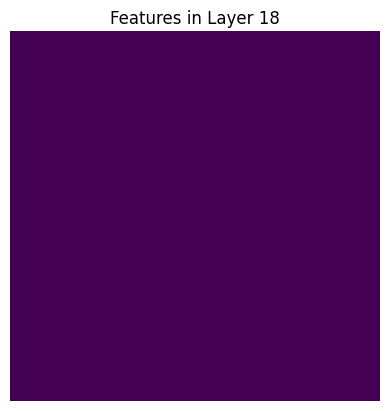

In [195]:
def viz_inter_features(image_path, transformations, model, target_layer):
    # Load and preprocess the image
    tensor = transformations(Image.open(image_path).convert("RGB").resize((128, 128))).to(device)

    # Extract intermediate features from the target layer
    intermediate_features = ext_inter_features(model, tensor.unsqueeze(0), target_layer)

    return intermediate_features

for i in range(len(model.encoder)):
    features = viz_inter_features(image_path, transformations, model, i)
    feature_list = []
    for j in range(len(features)):
        feature = features[j][0, 0].cpu().detach()
        feature_list.append(feature)
        plt.imshow(feature, cmap='viridis')
        plt.axis('off')
        plt.title(f'Features in Layer {i}')
        plt.show()

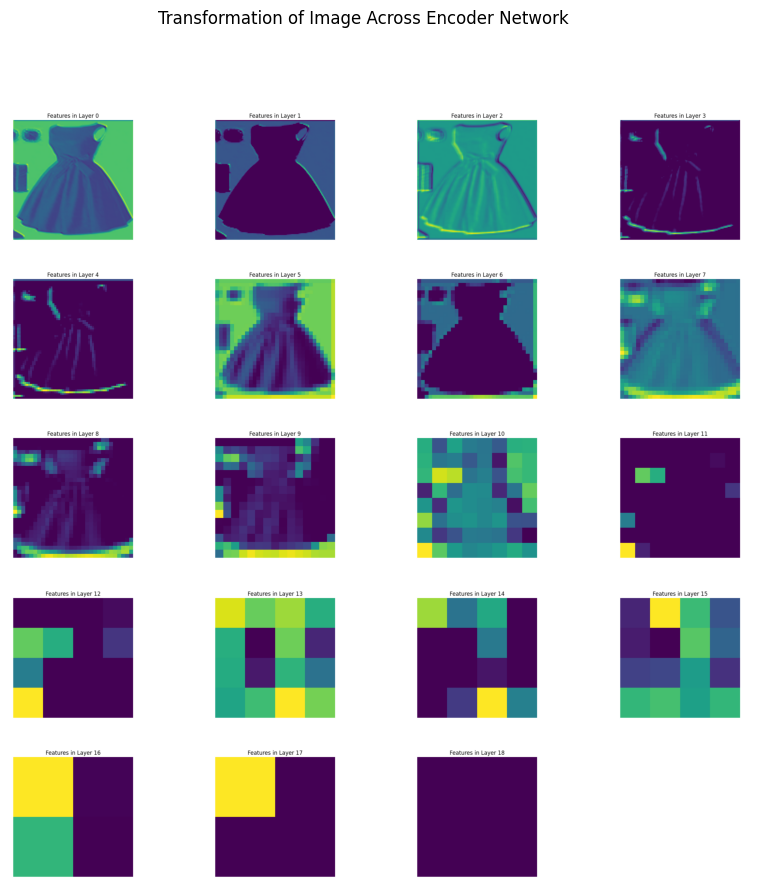

In [11]:
encoding_path = './results/image_encoding/dress/'
image_files = sorted([file for file in os.listdir(encoding_path) if file.endswith('.png')])

# Create a subplot grid based on the number of images
num_images = len(image_files)
rows = 5
cols = (num_images // rows) + 1

# Create a subplot grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Add Title
plt.suptitle("Transformation of Image Across Encoder Network")

# Iterate over the images and display them in the grid
for i in range(rows):
    for j in range(cols):
        # Calculate the index in the image_files list
        idx = i * cols + j

        # Check if the index is within number of images
        if idx < num_images:
            # Construct the path to current image
            image_path = os.path.join(encoding_path, image_files[idx])

            # Open and display the image
            img = Image.open(image_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
        else:
            # If there are fewer images than expected, leave the subplot blank
            axs[i, j].axis('off')

plt.show()

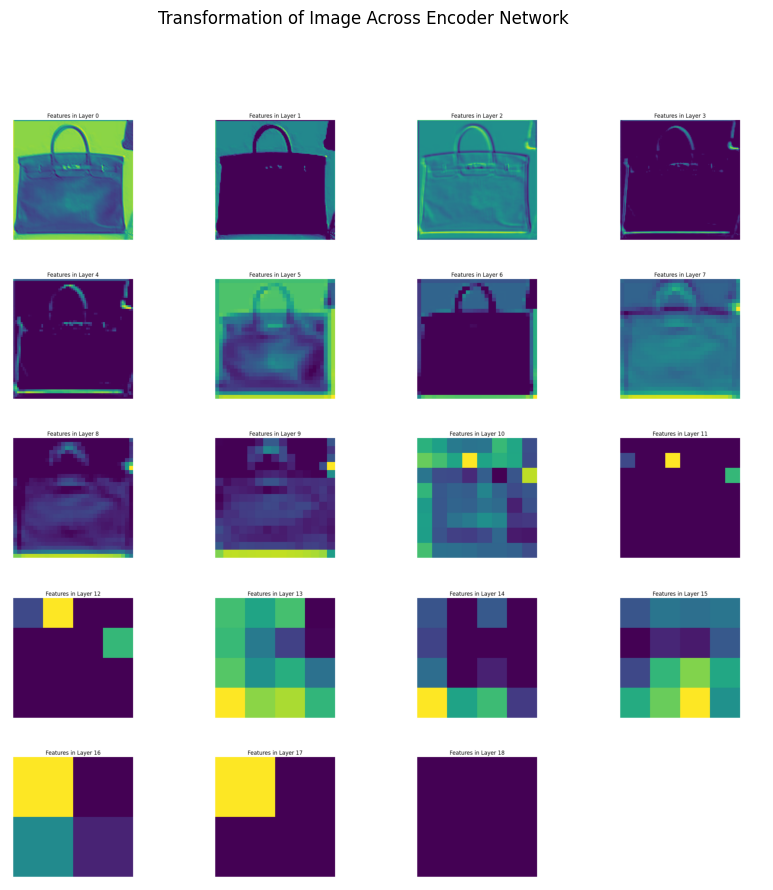

In [13]:
encoding_path = './results/image_encoding/handbag//'
image_files = sorted([file for file in os.listdir(encoding_path) if file.endswith('.png')])

# Create a subplot grid based on the number of images
num_images = len(image_files)
rows = 5
cols = (num_images // rows) + 1

# Create a subplot grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Add Title
plt.suptitle("Transformation of Image Across Encoder Network")

# Iterate over the images and display them in the grid
for i in range(rows):
    for j in range(cols):
        # Calculate the index in the image_files list
        idx = i * cols + j

        # Check if the index is within number of images
        if idx < num_images:
            # Construct the path to current image
            image_path = os.path.join(encoding_path, image_files[idx])

            # Open and display the image
            img = Image.open(image_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
        else:
            # If there are fewer images than expected, leave the subplot blank
            axs[i, j].axis('off')

plt.show()